In [17]:
# Webスクレピングに最低限必要なライブラリをインポート
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [ ]:
# アクセスしたいWebサイトのURLを指定
url = 'https://www.mlit.go.jp/kankocho/tokei_hakusyo/shukuhakutokei.html'

# WebサーバーにHTTPリクエストを送信
# レスポンスを変数に格納しておく
res = requests.get(url)

In [13]:
res.encoding = res.apparent_encoding  # レスポンスのエンコーディングを設定

print(f"レスポンス：{res}")  # レスポンスオブジェクトを表示
print(f"レスポンスの型：{type(res)}")  # レスポンスオブジェクトの型を表示
print(f"ステータスコード：{res.status_code}")  # ステータスコードを表示
print(f"ステータスメッセージ：{res.reason}")  # ステータスメッセージを表示

print(f"リクエスト：{res.request}")  # リクエストオブジェクトを表示
print(f"リクエストの型：{type(res.request)}")  # リクエストオブジェクトの型を表示
print(f"リクエストヘッダー：{res.request.headers}")  # リクエストヘッダーを表示
print(f"リクエストメソッド：{res.request.method}")  # リクエストメソッドを表示
print(f"リクエストURL：{res.request.url}")  # リクエストURLを表示

レスポンス：<Response [200]>
レスポンスの型：<class 'requests.models.Response'>
ステータスコード：200
ステータスメッセージ：OK
リクエスト：<PreparedRequest [GET]>
リクエストの型：<class 'requests.models.PreparedRequest'>
リクエストヘッダー：{'User-Agent': 'python-requests/2.32.5', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}
リクエストメソッド：GET
リクエストURL：https://www.mlit.go.jp/kankocho/tokei_hakusyo/shukuhakutokei.html


## スクレイピングでデータを取得

In [14]:
# レスポンスの HTML から BeautifulSoup オブジェクトを作る
soup = BeautifulSoup(res.text, 'html.parser')

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

# --- STEP 1: WebサイトのHTMLをスクレイピングしてURLを特定する ---

# 1. 観光庁の宿泊旅行統計のトップページ
base_url = 'https://www.mlit.go.jp/kankocho/tokei_hakusyo/shukuhakutokei.html'

print("WebサイトのHTMLを取得中...")
# サイトにアクセス
response = requests.get(base_url)
response.encoding = response.apparent_encoding # 文字化け防止
soup = BeautifulSoup(response.text, 'html.parser')

# 2. ページ内の全てのリンク（<a>タグ）を解析して目的のExcelを探す
excel_url = ""
links = soup.find_all('a')

print("ExcelファイルのURLを検索中...")
for link in links:
    text = link.get_text(strip=True)
    href = link.get('href')
    
    # 条件：リンクテキストに「令和5年」と「集計結果」が含まれ、リンク先が「.xlsx」であること
    if href and '令和5年' in text and '集計結果' in text and '.xlsx' in href:
        # 相対パスを絶対パス（https://...）に変換
        if href.startswith('/'):
            excel_url = 'https://www.mlit.go.jp' + href
        else:
            excel_url = href
        break

# サーバー負荷への配慮（課題要件）
time.sleep(1)

# 結果の確認
if excel_url:
    print(f"成功。特定したURL: {excel_url}")
else:
    print("条件に一致するリンクが見つかりませんでした。")

# --- STEP 2: 特定したURLのデータをデータフレームに読み込む ---

if excel_url:
    print("Excelデータをデータフレームとして読み込み中...")
    # 特定したURLから「第2表」のシートを抽出
    excel_file = pd.ExcelFile(excel_url)
    target_sheet = [s for s in excel_file.sheet_names if '第2表' in s][0]
    
    # 都道府県データが始まる位置（header=9）を指定して読み込み
    df_raw = pd.read_excel(excel_url, sheet_name=target_sheet, header=9)
    
    # 最初の数行を表示して、正しく取得できているか確認
    print("\n--- 取得データの冒頭 ---")
    print(df_raw.head())

WebサイトのHTMLを取得中...
ExcelファイルのURLを検索中...
成功！特定したURL: https://www.mlit.go.jp/kankocho/content/001750679.xlsx
Excelデータをデータフレームとして読み込み中...

--- 取得データの冒頭 ---
   　03岩手県     5855350    2248780    3590880     874610    165670     693250  \
0  　04宮城県  10072130.0  3432230.0  6526080.0   893920.0  330170.0   544370.0   
1  　05秋田県   3000970.0  1277710.0  1713450.0   394080.0  213740.0   170530.0   
2  　06山形県   4566630.0  2072820.0  2484380.0   733630.0  528130.0   196080.0   
3  　07福島県   9686880.0  4240040.0  5400750.0  2177940.0  492500.0  1664780.0   
4  　08茨城県   7508120.0  1924470.0  5570100.0   879910.0  455390.0   424510.0   

     1644570    347070    1297500    2729690    1266370    1463330     606480  \
0  3595550.0  413710.0  3110940.0  3504120.0  1077450.0  2426670.0  2078540.0   
1  1117340.0  362030.0   755310.0  1316470.0   615100.0   701370.0   173080.0   
2  1752000.0  688570.0  1063430.0  1576540.0   670950.0   905590.0   504460.0   
3  3040480.0  667940.0  2347110.0  2668940.0  14

## DBへスクレイピングで取得したデータを格納

In [12]:
import sqlite3

In [13]:
path = ''
db_name = 'sightseeing.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)

    # カーソルオブジェクトを取得
    cur = conn.cursor()

    # SQL文の作成（トリプルクォートで囲むのが安全です）
    sql = '''
    CREATE TABLE IF NOT EXISTS sightseeing_stats (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        prefecture TEXT NOT NULL,
        japanese_guests INTEGER,
        foreign_guests INTEGER,
        inbound_ratio REAL,
        created_at TIMESTAMP DEFAULT (DATETIME('now', 'localtime'))
    );
    '''

    # SQL文の実行
    cur.execute(sql)
    print("テーブルの作成に成功しました。")

except sqlite3.Error as e:
    print('エラーが発生しました:', e)

finally:    
    # DBへの接続を閉じる
    conn.close()

テーブルの作成に成功しました。


In [52]:
# --- 1. 名前の入っている列を自動特定 ---
pref_col_idx = None
for i in range(df_raw.shape[1]):
    sample_val = str(df_raw.iloc[0, i])
    if any(x in sample_val for x in ["都", "道", "府", "県"]):
        pref_col_idx = i
        break
if pref_col_idx is None: pref_col_idx = 1 

# --- 2. データを多めに取ってから「事務局」「運輸局」などを完全に除外する ---
df_final = df_raw.iloc[0:100, [pref_col_idx, pref_col_idx + 1, pref_col_idx + 2]].copy()
df_final.columns = ['都道府県', '日本人宿泊者数', '外国人宿泊者数']

# 文字列として扱い、不要な行政機関名が含まれる行を除外
df_final['都道府県'] = df_final['都道府県'].astype(str)
# 「事務局」をリストに追加しました
exclude_keywords = '運輸局|合計|ブロック|全国|地区|事務局|小計'
df_final = df_final[~df_final['都道府県'].str.contains(exclude_keywords, na=False)]

# 名前が空だったり、ただの数字だけの行を掃除
df_final = df_final[df_final['都道府県'].str.contains('都|道|府|県', na=False)]

# 純粋な都道府県だけを47件抽出
df_final = df_final.head(47).copy()

# --- 3. 数値の整理と計算 ---
df_final['日本人宿泊者数'] = pd.to_numeric(df_final['日本人宿泊者数'], errors='coerce').fillna(0).astype(int)
df_final['外国人宿泊者数'] = pd.to_numeric(df_final['外国人宿泊者数'], errors='coerce').fillna(0).astype(int)
df_final['インバウンド比率(%)'] = (df_final['外国人宿泊者数'] / (df_final['日本人宿泊者数'] + df_final['外国人宿泊者数']).replace(0,1)) * 100

# --- 4. DB保存 ---
db_name = 'sightseeing.db'
conn = sqlite3.connect(db_name)
cur = conn.cursor()
cur.execute("DELETE FROM sightseeing_stats")
sightseeing_data = []
for index, row in df_final.iterrows():
    sightseeing_data.append((str(row['都道府県']), int(row['日本人宿泊者数']), int(row['外国人宿泊者数']), float(row['インバウンド比率(%)'])))

sql = "INSERT INTO sightseeing_stats (prefecture, japanese_guests, foreign_guests, inbound_ratio) VALUES (?, ?, ?, ?);"
cur.executemany(sql, sightseeing_data)
conn.commit()
conn.close()

print("47都道府県のDBを完成させました。")
print("確認（トップ5の名前）:", df_final['都道府県'].head(5).tolist())

47都道府県のDBを完成させました。
確認（トップ5の名前）: ['\u300004宮城県', '\u300005秋田県', '\u300006山形県', '\u300007福島県', '\u300008茨城県']


In [53]:
path = ''
db_name = 'sightseeing.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)
    cur = conn.cursor()

    # データを参照するSQL
    sql = "SELECT * FROM sightseeing_stats;"

    # SQL文の実行
    cur.execute(sql)

except sqlite3.Error as e:
    print('エラーが発生しました:', e)

else:
    print(f"{'ID':<3} | {'都道府県':<6} | {'日本人':<10} | {'外国人':<10} | {'比率':<5}")
    print("-" * 60)
    
    for row in cur:
        # rowの中身をテーブル設計（6列）に合わせて展開します
        # id, 都道府県, 日本人, 外国人, 比率, 作成日時
        idx, pref, japanese, foreign, ratio, created_at = row
        
        # 取得した値を表示
        print(f"{idx:<3} | {pref:<8} | {japanese:>10,} | {foreign:>10,} | {ratio:>5.1f}%")

finally: 
    # DBへの接続を閉じる
    conn.close()

ID  | 都道府県   | 日本人        | 外国人        | 比率   
------------------------------------------------------------
695 | 　04宮城県   | 10,072,130 |  3,432,230 |  25.4%
696 | 　05秋田県   |  3,000,970 |  1,277,710 |  29.9%
697 | 　06山形県   |  4,566,630 |  2,072,820 |  31.2%
698 | 　07福島県   |  9,686,880 |  4,240,040 |  30.4%
699 | 　08茨城県   |  7,508,120 |  1,924,470 |  20.4%
700 | 　09栃木県   | 12,250,450 |  7,951,160 |  39.4%
701 | 　10群馬県   | 10,255,390 |  6,649,810 |  39.3%
702 | 　11埼玉県   |  5,242,390 |  1,021,130 |  16.3%
703 | 　12千葉県   | 27,773,740 | 18,494,160 |  40.0%
704 | 　13東京都   | 99,447,220 | 47,541,860 |  32.3%
705 | 　14神奈川県  | 28,267,370 | 14,078,670 |  33.2%
706 | 　15新潟県   |  9,586,960 |  4,527,250 |  32.1%
707 | 　16富山県   |  3,933,900 |  1,282,500 |  24.6%
708 | 　17石川県   |  8,726,180 |  5,738,600 |  39.7%
709 | 　18福井県   |  3,244,790 |  1,465,740 |  31.1%
710 | 　19山梨県   |  7,965,990 |  5,911,430 |  42.6%
711 | 　20長野県   | 17,966,840 | 12,039,800 |  40.1%
712 | 　21岐阜県   |  7,013,490 |  5,010,900 |

## データを元にグラフに可視化

/var/folders/0c/j668lfqn3qngsbyv_k5drwwc0000gn/T/ipykernel_16240/3480282935.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_jp_top5, x='prefecture', y='japanese_guests', palette='Blues_d', ax=ax1)
/var/folders/0c/j668lfqn3qngsbyv_k5drwwc0000gn/T/ipykernel_16240/3480282935.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_foreign_top5, x='prefecture', y='foreign_guests', palette='Oranges_d', ax=ax2)


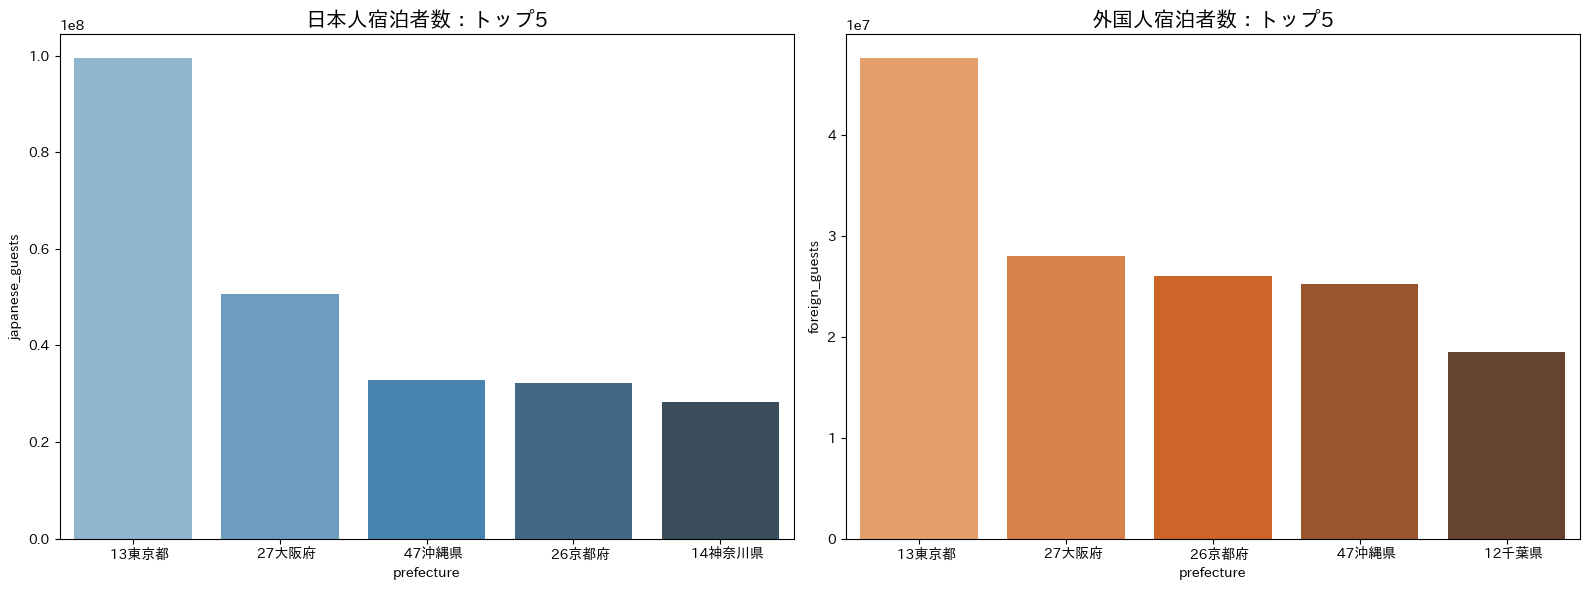

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib



def plot_top5_final_v2():
    db_name = 'sightseeing.db'
    conn = sqlite3.connect(db_name)
    df = pd.read_sql("SELECT * FROM sightseeing_stats", conn)
    conn.close()

    df_jp_top5 = df.sort_values('japanese_guests', ascending=False).head(5)
    df_foreign_top5 = df.sort_values('foreign_guests', ascending=False).head(5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.barplot(data=df_jp_top5, x='prefecture', y='japanese_guests', palette='Blues_d', ax=ax1)
    ax1.set_title("日本人宿泊者数：トップ5", fontsize=15)

    sns.barplot(data=df_foreign_top5, x='prefecture', y='foreign_guests', palette='Oranges_d', ax=ax2)
    ax2.set_title("外国人宿泊者数：トップ5", fontsize=15)

    plt.tight_layout()
    plt.show()

plot_top5_final_v2()

/var/folders/0c/j668lfqn3qngsbyv_k5drwwc0000gn/T/ipykernel_16240/1882651687.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ratio_top, x='prefecture', y='inbound_ratio', palette='viridis')


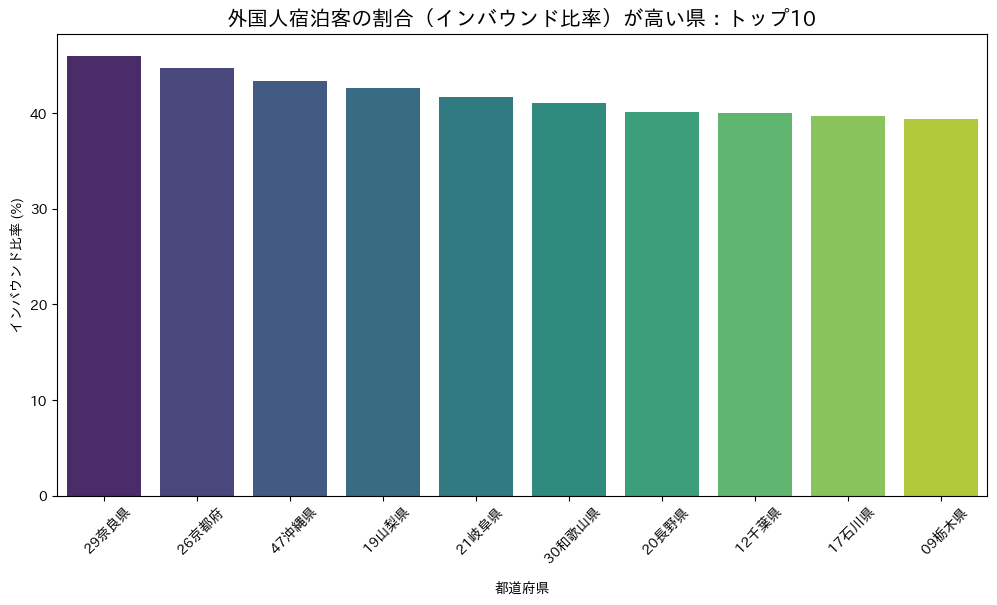

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

def plot_inbound_ratio_ranking():
    db_name = 'sightseeing.db'
    conn = sqlite3.connect(db_name)
    df = pd.read_sql("SELECT * FROM sightseeing_stats", conn)
    conn.close()

    # インバウンド比率（外国人客の割合）でソートしてトップ10を抽出
    df_ratio_top = df.sort_values('inbound_ratio', ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_ratio_top, x='prefecture', y='inbound_ratio', palette='viridis')
    
    plt.title("外国人宿泊客の割合（インバウンド比率）が高い県：トップ10", fontsize=15)
    plt.ylabel("インバウンド比率 (%)")
    plt.xlabel("都道府県")
    plt.xticks(rotation=45)
    plt.show()

plot_inbound_ratio_ranking()

In [60]:
class SightseeingReporter:
    def __init__(self, db_name):
        self.db_name = db_name

    def get_prefecture_report(self, target_pref):
        """
        指定された県のデータをDBから取得し、分析レポートを生成する
        """
        conn = sqlite3.connect(self.db_name)
        # 指定された県名を検索（部分一致対応）
        query = "SELECT * FROM sightseeing_stats WHERE prefecture LIKE ?"
        df = pd.read_sql(query, conn, params=(f'%{target_pref}%',))
        
        # 全体平均を取得（比較用）
        df_all = pd.read_sql("SELECT AVG(inbound_ratio) as avg_ratio FROM sightseeing_stats", conn)
        avg_ratio = df_all['avg_ratio'][0]
        conn.close()

        if df.empty:
            return f"'{target_pref}' のデータが見つかりませんでした。"

        row = df.iloc[0]
        pref_name = row['prefecture']
        ratio = row['inbound_ratio']
        
        # 動的なコメント生成
        status = "インバウンド特化型" if ratio > avg_ratio else "国内需要中心型"
        
        report = f"""
【観光分析レポート：{pref_name}】
-----------------------------------------
■ 外国人客の割合：{ratio:.1f}% （全国平均：{avg_ratio:.1f}%）
■ 分析結果：この県は「{status}」の傾向があります。
■ 考察：
   比率が全国平均を{'上回って' if ratio > avg_ratio else '下回って'}おり、
   {'国内外の観光客からバランス良く選ばれています。' if ratio > avg_ratio else '日本人観光客にとっての定番地としての側面が強いと言えます。'}
-----------------------------------------
        """
        return report

# --- 実行 ---
reporter = SightseeingReporter('sightseeing.db')

# 比率ランキングで1位だった奈良県を分析してみる
print(reporter.get_prefecture_report("奈良県"))


【観光分析レポート：　29奈良県】
-----------------------------------------
■ 外国人客の割合：46.0% （全国平均：31.9%）
■ 分析結果：この県は「インバウンド特化型」の傾向があります。
■ 考察：
   比率が全国平均を上回っており、
   国内外の観光客からバランス良く選ばれています。
-----------------------------------------
        
